<a href="https://colab.research.google.com/github/KonstantinSV/Project-A-B-testing/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Проект: А/В тестирование**

Набор данных содержит результат A / B-теста, в котором двум группам, (контрольной и проверочной), были представлены старая и новая страницы сайта соответственно. 

Цель теста - определить, привела ли новая страница к значительному увеличению конверсий по сравнению со старой страницей.

Данные для обучения:

Датасет на Kaggle - https://www.kaggle.com/zhangluyuan/ab-testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# Чтение и просмотр данных
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/A B Testing/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Коичество пользователей из каждой группы и страницы которые они посмотрели. 
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

1928 пользователей из контрольной группы просмотрели новую страницу и 1965 пользователей из проверочной группы просмотрели старую страницу.
Для чистоты эксперемента необходимо удалить пользователей из контрольной группы просмотревших новую страницу и пользователей из проверочной группы просмотревших старую страницу.

In [4]:
# Удаление пользователей
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Проверка на повторяющихся пользователей

In [5]:
df_cleaned['user_id'].duplicated().sum()

1

Найден один повторяющийся пользователь. Определим его id

In [6]:
# Пользователь из проверочной выборки с id - 773192 дважды просмотрел новую страницу и ни разу не кликнул.
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [7]:
# Для исключения учета повторений действий пользователей, оставим в DataFrame только первое действие пользователей. 
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep="first")

**Анализ данных**

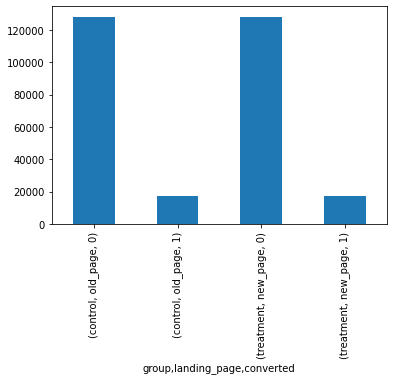

In [8]:
# Гистограмма  показывает пропорции конверсии в обоих группах
groups = df_cleaned.groupby(['group','landing_page','converted']).size()
groups.plot.bar()

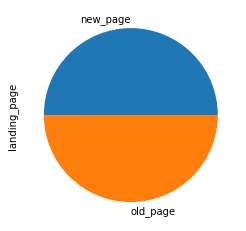

In [9]:
# Круговая диаграмма показывает количество пользователей в каждой группе
df_cleaned['landing_page'].value_counts().plot.pie()

**Подготовка данных**

In [10]:
# 1) Разделение группы на два отдельныхх DataFrames 
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']
# 2) Разделение каждый DataFrame еще на две группы (A-click, A-noclick, B-click, B-noclick) и посчитаем кол-во пользователей в каждой
a_click = a.converted.sum()
a_noclick = a.converted.size - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()
# 3) Для удобства сохраним данные всех групп в массив numpy
total = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [11]:
# Определение p-value
print(scipy.stats.chi2_contingency(total,correction=False)[1])

0.18988337448194853


Расчетное значение p-value составило 19%, что больше уровеня значимости (альфа), который равен 5%, то есть результат является статистически не значимым.

**Вывод**: Конверсия между старой и новой веб-страницей не имеет значения.

In [12]:
# Проверка сделанного вывода с помощью расчета CTR для контрольной и проверочной групп
a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)
print(a_CTR, b_CTR)

0.1203863045004612 0.11880806551510564


Разница между CTR минимальна, что говорит о том, что вывод был сделан правильно.